# Saliency maps tutorial

In order to generate saliency maps, you need the dataset in the proper format (see the [prepare data tutorial](https://meegnet.readthedocs.io/en/latest/preparedata.html), and an architecture, trained or not (seeing saliency maps with an untrained architecture should be noise).

The first step to generating visualisation for the saliency maps will be to first compute the saliency maps.

## Generate Saliency maps

First we will set all the needed imports

In [1]:
import os
from copy import deepcopy
from collections import defaultdict
import pandas as pd
import numpy as np
from tqdm import tqdm
from meegnet.parsing import parser, save_config
from meegnet.dataloaders import Dataset
from meegnet.network import Model
from meegnet.viz import compute_saliency_maps, generate_saliency_figure
from meegnet_functions import load_single_subject

/home/arthur/.pyvenv/meegnet/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This next section sets up all the parameters we will need for the saliency maps computations

In [2]:
# We set up our data to be 3 channel types (MAG GRAD GRAD),
# 102 sensor locations (Elekta Neuromag Vector View 306 channel MEG),
# and 400 time samples for 800ms of signal sampled as 500Hz.
n_channels = "ALL"
input_size = (3, 102, 400)

n_outputs = 2 # using auditory vs rest stimulus classification -> 2 classes
n_subjects = 1000 # For this tutorial we will only use a fraction of the data
n_samples = None # We will use all trials for each subject

# Setting up paths
classif = "eventclf" # also used for naming files and for model name
save_path = f"/home/arthur/nvme/{classif}"
model_path = save_path

### Loading the Model

Loading the model from pretrained, using the from_pretrained method, can also load another model using the load method. It is also possible to comment both lines in order to use an untrained model.

In [3]:
# setting up a seed for reproducibility (will be used for numpy, pandas, torch, and the meegnet library)
seed = 42 

# net option can be "meegnet", "eegnet" etc, see documentation
net_option = "meegnet" 

# name of the model
name = f"{classif}_{net_option}_{seed}_{n_channels}"

my_model = Model(name, net_option, input_size, n_outputs, save_path=save_path)
# my_model.from_pretrained()
model_path = os.path.join(save_path, name + ".pt")
my_model.load(model_path)
print("Model Loaded.")

Model Loaded.


### Loading data

If the data was set-up correctly, we use participands_info.csv in order to generate a subject list and select a random subject for generating figures.

In [4]:
dataset = Dataset(
    sfreq=500, # sampling frequency of 500Hz
    n_subjects=n_subjects,
    n_samples=n_samples,
    sensortype='ALL', # we use MAG GRAD GRAD here
    lso=True,
    random_state=seed,
    target_labels = ['visual', 'auditory']
)
dataset.preload(save_path)

np.random.seed(seed)
random_subject_idx = np.random.choice(np.arange(len(dataset.subject_list)))

### Compute Saliency maps

Finally, we compute the saliency maps and save them.

In [5]:
# This will create a saliency maps path inside the save path
# Please don't change or it might break code later on
sal_path = os.path.join(save_path, "saliency_maps", name)
if not os.path.exists(sal_path):
    os.makedirs(sal_path)

confidence = 0.95

for sub in dataset.subject_list:
    # The next two lines allow to pick-up where we left off and not compute saliencies each time this cell is ran.
    sub_files = [a for a in os.listdir(sal_path) if sub in a]
    if len(sub_files) != n_outputs * 2: # 2 file (positive and negative saliencies) per label.
        sub_dataset = deepcopy(dataset)
        sub_dataset.load(save_path, one_sub=sub)
        if len(dataset) > 0:
            compute_saliency_maps(
                sub_dataset,
                my_model.net,
                sal_path,
                threshold = confidence,
                epoched = True,
            )

### Generating figures

Generating figure for sensors: ['MAG', 'PLANAR1', 'PLANAR2']
For the visual vs resting state classification


 18%|███████▍                                 | 101/554 [00:08<00:40, 11.08it/s]

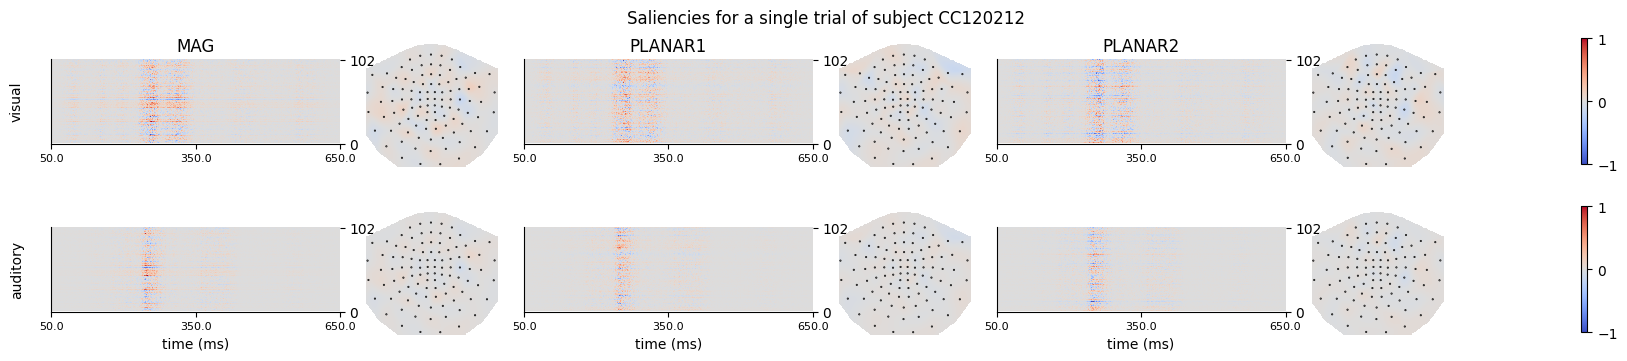

Figure generated: /home/arthur/nvme/eventclf/eventclf_CC120212_single_trial_saliencies.png


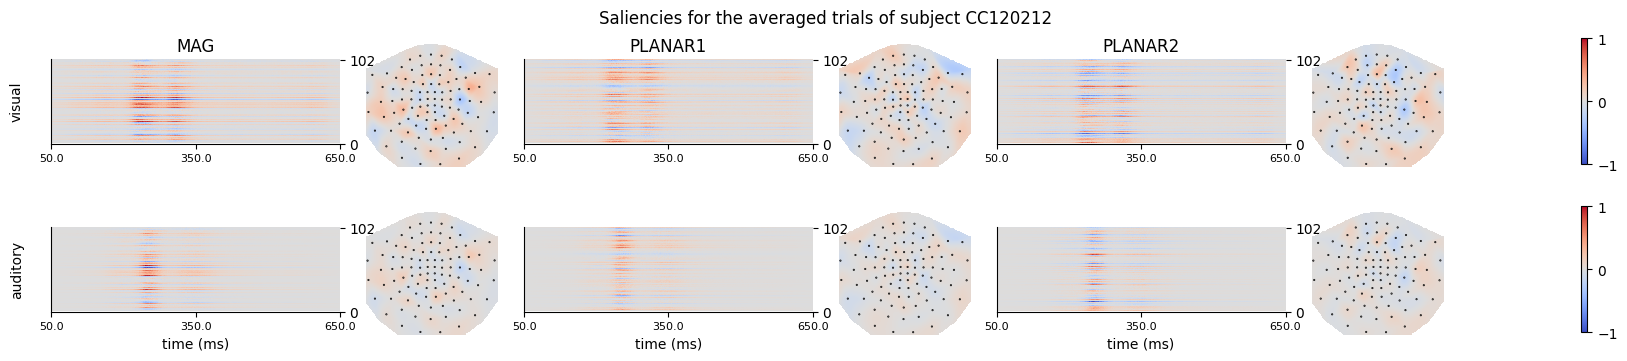

 19%|███████▊                                 | 105/554 [00:11<02:32,  2.95it/s]

Figure generated: /home/arthur/nvme/eventclf/eventclf_CC120212_all_trials_saliencies.png


100%|█████████████████████████████████████████| 554/554 [01:10<00:00,  7.81it/s]


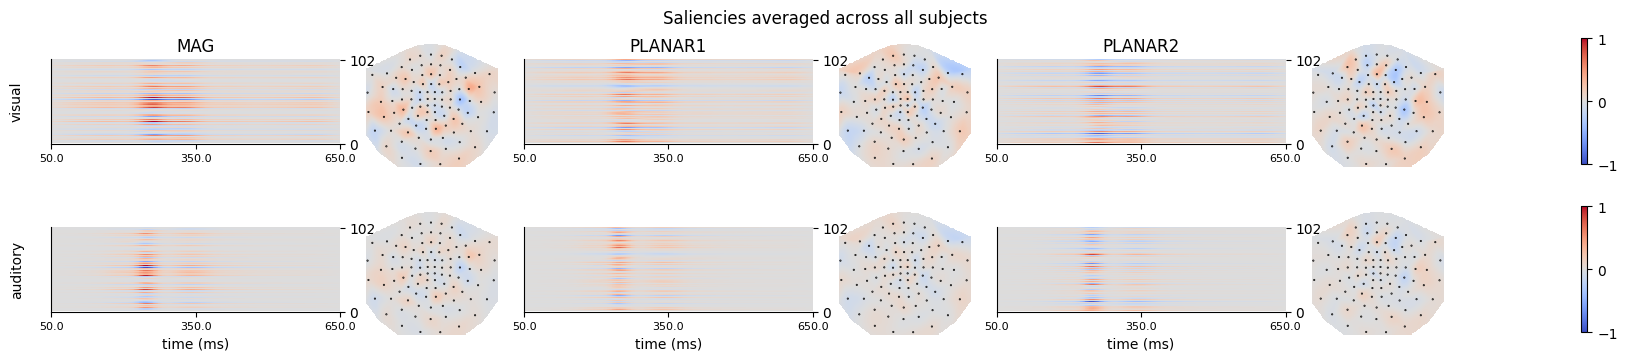

Figure generated: /home/arthur/nvme/eventclf/eventclf_saliencies.png


In [6]:
sensors = ["MAG", "PLANAR1", "PLANAR2"]
stim_tick = 75 # The index for the stimulus timing (150ms in a 800ms trial at 500Hz)
saliency_types = ("pos", "neg")
cmap = "coolwarm"

fig_path = os.path.join(save_path, "figures")
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
    
info = np.load("../camcan_sensor_locations.npy", allow_pickle=True).tolist()

# Some tested aletrnatives for the colormap:
# cmap = sns.color_palette("icefire", as_cmap=True)
# cmap = sns.color_palette("coolwarm", as_cmap=True, center="dark")
# cmap = "inferno"
# cmap = "seismic"

# if raw_path if left empty, or set to None, the function will use mne Elekta vectorview 306 for sensor location 
raw_path = None
def get_saliency_data(saliency_dict):
    saliencies = {}
    operation = lambda a, b: a - b
    for lab, pos in saliency_dict["pos"].items():
        saliencies[lab] = operation(np.array(pos), np.array(saliency_dict["neg"][lab]))
    return saliencies

all_saliencies = defaultdict(lambda: defaultdict(lambda: []))

print(f"Generating figure for sensors: {sensors}")
print(f"For the visual vs resting state classification")

# First load all computed saliencies
for i, sub in enumerate(tqdm(dataset.subject_list)):
    sub_saliencies = defaultdict(lambda: {})
    for label in dataset.target_labels:
        nofile = False
        for saliency_type in saliency_types:
            lab = f"_{label}"
            saliency_file = os.path.join(
                sal_path,
                f"{sub}{lab}_{saliency_type}_sal_{confidence}confidence.npy",
            )
            if os.path.exists(saliency_file):
                try:
                    saliencies = np.load(saliency_file)
                    sub_saliencies[saliency_type][label] = saliencies
                except IOError:
                    logging.warning(f"Error loading {saliency_file}")
                    nofile = True
                    continue
            else:
                nofile = True
                continue
            if len(saliencies.shape) == 3:
                saliencies = saliencies[np.newaxis, ...]  # If only one saliency in file
            elif len(saliencies.shape) != 4:
                nofile = True
                continue
            all_saliencies[saliency_type][label].append(saliencies.mean(axis=0))

        if nofile:
            continue

    skip = False
    if i == random_subject_idx:
        data_dict = get_saliency_data(sub_saliencies)
        for val in data_dict.values():
            if val.size == 0:
                skip = True
                break
        if skip:
            random_subject_idx += 1
            continue
        temp = {
            key: val[np.random.choice(np.arange(len(val)))]
            for key, val in data_dict.items()
        }
        out_path = generate_saliency_figure(
            temp,
            info=info,
            save_path=save_path,
            suffix=f"{classif}_{sub}_single_trial",
            sensors=sensors,
            title=f"Saliencies for a single trial of subject {sub}",
            cmap=cmap,
            show=True,
            edge=50,
            topomap="average",
        )
        print(f"Figure generated: {out_path}")
        temp = {key: np.mean(val, axis=0) for key, val in data_dict.items()}
        out_path = generate_saliency_figure(
            temp,
            info=info,
            save_path=save_path,
            suffix=f"{classif}_{sub}_all_trials",
            sensors=sensors,
            title=f"Saliencies for the averaged trials of subject {sub}",
            cmap=cmap,
            show=True,
            edge=50,
            topomap="average",
        )
        print(f"Figure generated: {out_path}")
    if skip:
        random_subject_idx += 1
        continue

for label in dataset.target_labels:
    for saliency_type in saliency_types:
        if type(all_saliencies[saliency_type][label]) == list:
            all_saliencies[saliency_type][label] = np.array(
                all_saliencies[saliency_type][label]
            )
            
data_dict = get_saliency_data(all_saliencies)
final_dict = {key: np.mean(val, axis=0)[np.newaxis] for key, val in data_dict.items()}

out_path = generate_saliency_figure(
    final_dict,
    info=info,
    save_path=save_path,
    suffix=f"{classif}",
    sensors=sensors,
    title=f"Saliencies averaged across all subjects",
    cmap=cmap,
    show=True,
    edge=50,
    topomap="average",
)
print(f"Figure generated: {out_path}")

In the case of epoched data with fixed timing, it might be interresting to look at the saliency at specific timings.

Generating figure for sensors: ['MAG', 'PLANAR1', 'PLANAR2']
For the visual vs resting state classification


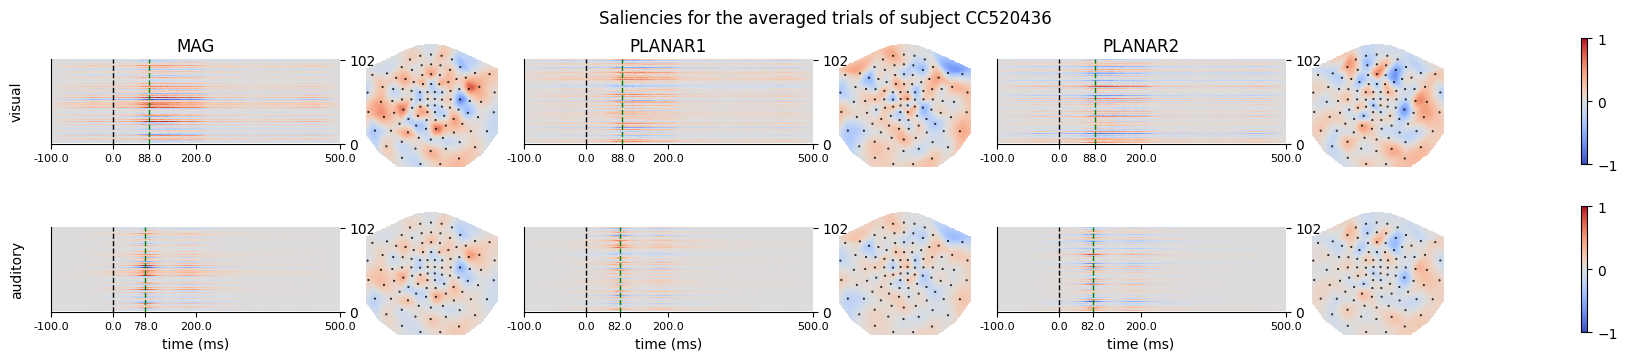

Figure generated: /home/arthur/nvme/eventclf/eventclf_CC520436_all_trials_timing_saliencies.png


In [7]:
stim_tick = 150 # The timing for the stimulus is 150ms

# Choose a random subject:
random_sub_id = 42
sub = dataset.subject_list[random_sub_id]
i = random_sub_id


print(f"Generating figure for sensors: {sensors}")
print(f"For the visual vs resting state classification")

# Loading data and generating figure:
sub_saliencies = defaultdict(lambda: {})
for label in dataset.target_labels:
    nofile = False
    for saliency_type in saliency_types:
        lab = f"_{label}"
        saliency_file = os.path.join(
            sal_path,
            f"{sub}{lab}_{saliency_type}_sal_{confidence}confidence.npy",
        )
        if os.path.exists(saliency_file):
            try:
                saliencies = np.load(saliency_file)
                sub_saliencies[saliency_type][label] = saliencies
            except IOError:
                logging.warning(f"Error loading {saliency_file}")
                nofile = True
                continue
        else:
            nofile = True
            continue
        if len(saliencies.shape) == 3:
            saliencies = saliencies[np.newaxis, ...]  # If only one saliency in file
        elif len(saliencies.shape) != 4:
            nofile = True
            continue
    if nofile:
        continue

data_dict = get_saliency_data(sub_saliencies)
for val in data_dict.values():
    if val.size == 0:
        skip = True
        break
temp = {key: np.mean(val, axis=0) for key, val in data_dict.items()}
out_path = generate_saliency_figure(
    temp,
    info=info,
    save_path=save_path,
    suffix=f"{classif}_{sub}_all_trials_timing",
    sensors=sensors,
    title=f"Saliencies for the averaged trials of subject {sub}",
    cmap=cmap,
    show=True,
    topomap="window",
    edge=50,
    stim_tick=stim_tick,
);
print(f"Figure generated: {out_path}");

The green dashed line is the timing of thew highest saliency in the trial, and the topomap corresponds to the timing.